In [47]:
import numpy as np
import pandas as pd
import scipy.io
from scipy.stats import itemfreq
from statistics import mode
import time
import multiprocessing as mp

import pydot

### Decision Tree class

In [93]:
class decision_tree:
    
    class node:
        def __init__(self, left, right, split_rule, is_leaf, label):
            self.left = left
            self.right = right
            self.split_rule = split_rule
            self.is_leaf = is_leaf
            self.label = label
    
    def __init__(self, max_depth=1e10):
        self.max_depth = max_depth

    def max_count(self, array):
        return max(set(array), key=array.tolist().count)
        
    # utility function for entropy calculation
    def entropy(self, indices):
        p = itemfreq(a)[:, 1].astype(float) / len(indices)
        return -p.dot(np.log2(p))
    
    # calculate entropy the number of instances in each class in known
    def entropy_n(self, all_n):
        p = all_n / (np.sum(all_n)+1e-20)
        return -p.dot(np.log2(p+1e-20))
    
    # calculate the impurity("badness") of the specified split on the input data
    def impurity(self, left_label_hist, right_label_hist):
        Sl = np.sum(left_label_hist)
        Sr = np.sum(right_label_hist)
        return (Sl*self.entropy_n(left_label_hist) + Sr * self.entropy_n(right_label_hist)) / (Sl+Sr)
    
    # find the threshold that best split the data points with a certain feature
    # Note: <= th goes to S_left and > th goes to S_right
    def find_threshold(self, feature, labels):
        all_f = sorted(set(feature)) # sorted in ascending order
        all_l = set(labels) # list unique labels
        
        freq_mat = np.zeros([len(all_f), len(all_l)])
        for i, f in enumerate(all_f):
            for j, l in enumerate(all_l):
                freq_mat[i, j] = len(labels[np.where(labels[np.where(feature==f)]==l)])
        
        # calculate the average of two neighboring values as threshold
        # iterates from min to max
        all_threshold = (np.hstack((all_f[1:], all_f[-1])) + all_f) / 2.
        
        # in the beginning, all goes to the right node
        n_left = np.zeros([len(all_l)])
        n_right = np.sum(freq_mat, axis=0)
        n_left_sum = 0
        min_threshold = all_threshold[0]
        min_H = self.impurity(n_left, n_right)
        # loop through all threshold to find the one with the minimum impurity
        for i, th in enumerate(all_threshold):
            n_left += freq_mat[i, :]
            n_right -= freq_mat[i, :]
            H = self.impurity(n_left, n_right)
            if H < min_H:
                min_H = H
                min_threshold = th
        return min_threshold, min_H
    
    
    # find the best feature and threshold to split data points
    def segmenter(self, data, labels, m=-1):
        d = data.shape[1]
        if m == -1:
            all_features = np.arange(d)
        else:
            all_features = np.random.choice(range(d), m, replace=False)
        min_H = 1e20
        min_th = 0
        min_i = 0
        for i in all_features:
            threshold, H = self.find_threshold(data[:, i], labels)
            if H < min_H:
                min_H = H
                min_th = threshold
                min_i = i
        return min_i, min_th
    
    # the recurrence function that builds the decision tree
    def grow_tree(self, S, depth, m=-1):
        if len(set(self.labels[S])) == 1 or depth >= self.max_depth: # pure node or reach maximum depth
            return self.node(left=None, right=None, split_rule=None, is_leaf=1, \
                             label=self.max_count(self.labels[S]))
        else:
            min_i, min_th = self.segmenter(self.data[S, :], self.labels[S], m=m)
            Sl = [j for j in S if self.data[j, min_i] <= min_th]
            Sr = [j for j in S if self.data[j, min_i] > min_th]
            if len(Sl) == 0 or len(Sr) == 0:
                return self.node(left=None, right=None, split_rule=None, is_leaf=1, \
                                 label=self.max_count(self.labels[S]))
            else:
                return self.node(left=self.grow_tree(Sl, depth+1, m), right=self.grow_tree(Sr,depth+1, m), \
                                 split_rule = (min_i, min_th), \
                            is_leaf=0, label=None)
        
    # train the decision tree
    def train(self, data, labels, m=-1):
        self.data = data
        self.labels = labels
        S = np.array(range(len(labels)))
        self.root = self.grow_tree(S, 1, m=m)
        self.data = None
        self.labels = None
        return self
        
    # predict labels of test data
    def predict(self, data, verbose=0):
        if data.ndim == 1: # special case of only 1 row (it becomes a 1d vector in numpy)
            data = np.reshape(data, [1, len(data)])
            N = 1
        else:
            N = data.shape[0]
        labels = np.zeros(N)    
            
        # predict each data point    
        for i in range(N):
            d = data[i, :]
            current_node = self.root
            depth = 0
            # going down along the tree
            while not current_node.is_leaf: # not reach leaf yet
                idx = current_node.split_rule[0]
                th = current_node.split_rule[1]
                if d[idx] <= th:
                    current_node = current_node.left
                    if verbose == 1 and depth == 0:
                        print('Feature %d <= %f' % (idx, th))
                    if verbose == 2:
                        print('Feature %d <= %f' % (idx, th))
                else:
                    current_node = current_node.right
                    if verbose == 1 and depth == 0:
                        print('Feature %d > %f' % (idx, th))
                    if verbose == 2:
                        print('Feature %d > %f' % (idx, th))
                depth += 1
            if verbose == 2:
                print('Classification: %d' % current_node.label)
                
            labels[i] = current_node.label
        return labels

    # calculate the prediction accuracy
    def accuracy(self, data, true_labels):
        labels = self.predict(data, verbose=False)
        N = len(labels)
        return np.sum(labels == true_labels) / float(N)
        
        

### Random Forest Class

In [94]:
# use multiproccessing to speed up
class random_forest:
    def __init__(self, n_trees=20, n_sample=1000, n_feature=-1, max_depth=1e10):
        self.n_trees = n_trees
        self.n_sample = n_sample
        self.n_feature = -1
        self.max_depth = max_depth
        self.trees = np.array([decision_tree(max_depth)] * n_trees)
        
    def train_parallel(self, data, labels, verbose=True):
        if self.n_feature == -1:
            d = data.shape[1]
            self.n_feature = int(np.sqrt(d)) # num of random features = sqrt(d) is a good guess
        pool = mp.Pool()
        results = np.zeros(self.n_trees, dtype=object)
        print('# Trees = %d' % self.n_trees)
        for i, dt in enumerate(self.trees):
#             print(i)
            idx = np.random.choice(range(len(data)), self.n_sample)
            sub_data = data[idx, :]
            sub_labels = labels[idx]
            results[i] = pool.apply_async(dt.train, args=(sub_data, sub_labels, self.n_feature,))
            if verbose:
                print('%d: Tree loaded.' % i)
#             dt.train(sub_data, sub_labels, m=self.n_feature) # activate the random feature mode
        self.trees = [p.get() for p in results]
        print('Trees trained.')
        pool.close()
        
    def train(self, data, labels):
        if self.n_feature == -1:
            d = data.shape[1]
            self.n_feature = int(np.sqrt(d)) # num of random features = sqrt(d) is a good guess
        print('# Trees = %d' % self.n_trees)
        for i, dt in enumerate(self.trees):
            print(i)
            idx = np.random.choice(range(len(data)), self.n_sample)
            sub_data = data[idx, :]
            sub_labels = labels[idx]
            dt.train(sub_data, sub_labels, m=self.n_feature) # activate the random feature mode
    
    def predict(self, data, verbose=0):
        if data.ndim == 1: # special case of only 1 row (it becomes a 1d vector in numpy)
            data = np.reshape(data, [1, len(data)])
            N = 1
        else:
            N = data.shape[0]
        labels = np.zeros(N)    
            
        # predict each data point    
        for i in range(N):
            votes = np.zeros(self.n_trees)
            for j, t in enumerate(self.trees):
                votes[j] = t.predict(data[i, :], verbose=verbose)
            labels[i] = t.max_count(votes)
        return labels
    
    def accuracy(self, data, true_labels):
        labels = self.predict(data, verbose=False)
        N = len(labels)
        return np.sum(labels == true_labels) / float(N)
     

### Utility

In [69]:
def normalize_row(X):
    Xn = np.zeros(X.shape)
    for i in range(X.shape[0]):
        x = X[i, :]
        Xn[i, :] = (x/(np.sqrt(x.dot(x))+1e-15))
    return Xn

In [70]:
def max_count(lst):
    return max(set(lst), key=lst.tolist().count)

### 1. spam

In [71]:
data = scipy.io.loadmat('spam_dist/spam_data.mat')
train_X = data['training_data']
train_y = data['training_labels'].ravel()
test_X = data['test_data']
len(train_X)

23702

In [72]:
S = np.random.choice(range(len(train_y)), int(len(train_y)/5*4), replace=False)
train_data = train_X[S, :]
train_labels = train_y[S]
S = np.setdiff1d(range(len(train_y)), S)
validation_data = train_X[S, :]
validation_labels = train_y[S]
print(train_data.shape)

(18961, 32)


#### Decision Tree

In [82]:
dt = decision_tree(15)
start = time.time()
dt.train(train_data, train_labels)
end = time.time()
print('Total training time: ', end-start)


l = dt.accuracy(train_data, train_labels)
print('Accuracy: ', l)

l = dt.accuracy(validation_data, validation_labels)
print('Accuracy: ', l)

Total training time:  9.92026662826538
Accuracy:  0.806866726438
Accuracy:  0.793714406243


In [87]:
dt.predict(train_X[0, :], verbose=2)

Feature 28 <= 0.500000
Feature 29 <= 0.500000
Feature 19 <= 0.500000
Feature 25 <= 1.500000
Feature 7 <= 0.500000
Feature 13 <= 0.500000
Feature 3 <= 0.500000
Feature 0 <= 0.500000
Feature 26 <= 0.500000
Feature 31 <= 0.500000
Feature 6 <= 0.500000
Feature 20 <= 0.500000
Feature 16 <= 0.500000
Feature 30 <= 0.500000
Classification: 0


array([ 0.])

#### Random Forest

In [95]:
n_trees=20
n_sample=18000
n_feature=-1
max_depth=30
rf = random_forest(n_trees=n_trees, n_sample=n_sample, n_feature=n_feature, max_depth=max_depth)
start = time.time()
rf.train_parallel(train_data, train_labels)
end = time.time()
print('Total training time: ', end-start)

l = rf.accuracy(train_data, train_labels)
print('Accuracy: ', l)

l = rf.accuracy(validation_data, validation_labels)
print('Accuracy: ', l)

# Trees = 20
0: Tree loaded.
1: Tree loaded.
2: Tree loaded.
3: Tree loaded.
4: Tree loaded.
5: Tree loaded.
6: Tree loaded.
7: Tree loaded.
8: Tree loaded.
9: Tree loaded.
10: Tree loaded.
11: Tree loaded.
12: Tree loaded.
13: Tree loaded.
14: Tree loaded.
15: Tree loaded.
16: Tree loaded.
17: Tree loaded.
18: Tree loaded.
19: Tree loaded.
Trees trained.
Total training time:  5.115397930145264
Accuracy:  0.814250303254
Accuracy:  0.810166631512


In [96]:
rf.predict(train_X[0, :], verbose=1)

Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 16 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000
Feature 19 <= 0.500000


array([ 0.])

#### Kaggle

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
# test tf-idf feature
from sklearn.feature_extraction.text import TfidfVectorizer
import glob
SPAM_DIR = 'spam/'
HAM_DIR = 'ham/'
TEST_DIR = 'test/'
NUM_TEST_EXAMPLES = 10000
spam_filenames = glob.glob('spam_dist/' + SPAM_DIR + '*.txt')
ham_filenames = glob.glob('spam_dist/' + HAM_DIR + '*.txt')
test_filenames = ['spam_dist/' + TEST_DIR + str(x) + '.txt' for x in range(NUM_TEST_EXAMPLES)]

all_text = []
for file in spam_filenames+ham_filenames: # use only training set data to build BOG
    with open(file, "r", encoding='utf-8', errors='ignore') as f:
        all_text.append(f.read())
        
all_test_text = []
for file in test_filenames: # use only training set data to build BOG
    with open(file, "r", encoding='utf-8', errors='ignore') as f:
        all_test_text.append(f.read())
        

In [47]:
# vectorizer = CountVectorizer(min_df=4) # min word length=4
vectorizer = TfidfVectorizer()
train_X = normalize_row(vectorizer.fit_transform(all_text).toarray())
test_X = normalize_row(vectorizer.transform(all_test_text).toarray())
train_y = np.concatenate((np.ones(len(spam_filenames)), np.zeros(len(ham_filenames))))

In [85]:
std = np.std(train_X, axis=0)
# use the max N variance word to build model
n_max = 2000
max_idx = std.argsort()[-n_max:]
train_X_max = train_X[:, max_idx]
test_X_max = test_X[:, max_idx]
print(train_X_max.shape)

(23702, 2000)


In [86]:
S = np.random.choice(range(len(train_y)), int(len(train_y)/5*4), replace=False)
train_data = train_X_max[S, :]
train_labels = train_y[S]
S = np.setdiff1d(range(len(train_y)), S)
validation_data = train_X_max[S, :]
validation_labels = train_y[S]


In [83]:
# tune random forest parameters
n_trees=128 # 128 is good
n_sample=18000
n_feature=-1 # -1 ==> sqrt(d)
max_depth=80 # deeper tree has lower bias

rf = random_forest(n_trees=n_trees, n_sample=n_sample, n_feature=n_feature, max_depth=max_depth)

start = time.time()
rf.train(train_data, train_labels) # use all data
end = time.time()
print('Total training time: ', end-start)

# Trees = 128
0: Tree loaded.
1: Tree loaded.
2: Tree loaded.
3: Tree loaded.
4: Tree loaded.
5: Tree loaded.
6: Tree loaded.
7: Tree loaded.
8: Tree loaded.
9: Tree loaded.
10: Tree loaded.
11: Tree loaded.
12: Tree loaded.
13: Tree loaded.
14: Tree loaded.
15: Tree loaded.
16: Tree loaded.
17: Tree loaded.
18: Tree loaded.
19: Tree loaded.
20: Tree loaded.
21: Tree loaded.
22: Tree loaded.
23: Tree loaded.
24: Tree loaded.
25: Tree loaded.
26: Tree loaded.
27: Tree loaded.
28: Tree loaded.
29: Tree loaded.
30: Tree loaded.
31: Tree loaded.
32: Tree loaded.
33: Tree loaded.
34: Tree loaded.
35: Tree loaded.
36: Tree loaded.
37: Tree loaded.
38: Tree loaded.
39: Tree loaded.
40: Tree loaded.
41: Tree loaded.
42: Tree loaded.
43: Tree loaded.
44: Tree loaded.
45: Tree loaded.
46: Tree loaded.
47: Tree loaded.
48: Tree loaded.
49: Tree loaded.
50: Tree loaded.
51: Tree loaded.
52: Tree loaded.
53: Tree loaded.
54: Tree loaded.
55: Tree loaded.
56: Tree loaded.
57: Tree loaded.
58: Tree l

In [84]:
l = rf.accuracy(validation_data, validation_labels)
print('Accuracy: ', l)

Accuracy:  0.974267032272


In [87]:
# train random forest for Kaggle submission
n_trees=128
n_sample=len(train_X_max)
n_feature=-1 # -1 ==> sqrt(d)
max_depth=80

rf = random_forest(n_trees=n_trees, n_sample=n_sample, n_feature=n_feature, max_depth=max_depth)

start = time.time()
rf.train(train_X_max, train_y) # use all data
end = time.time()
print('Total training time: ', end-start)

# Trees = 128
0: Tree loaded.
1: Tree loaded.
2: Tree loaded.
3: Tree loaded.
4: Tree loaded.
5: Tree loaded.
6: Tree loaded.
7: Tree loaded.
8: Tree loaded.
9: Tree loaded.
10: Tree loaded.
11: Tree loaded.
12: Tree loaded.
13: Tree loaded.
14: Tree loaded.
15: Tree loaded.
16: Tree loaded.
17: Tree loaded.
18: Tree loaded.
19: Tree loaded.
20: Tree loaded.
21: Tree loaded.
22: Tree loaded.
23: Tree loaded.
24: Tree loaded.
25: Tree loaded.
26: Tree loaded.
27: Tree loaded.
28: Tree loaded.
29: Tree loaded.
30: Tree loaded.
31: Tree loaded.
32: Tree loaded.
33: Tree loaded.
34: Tree loaded.
35: Tree loaded.
36: Tree loaded.
37: Tree loaded.
38: Tree loaded.
39: Tree loaded.
40: Tree loaded.
41: Tree loaded.
42: Tree loaded.
43: Tree loaded.
44: Tree loaded.
45: Tree loaded.
46: Tree loaded.
47: Tree loaded.
48: Tree loaded.
49: Tree loaded.
50: Tree loaded.
51: Tree loaded.
52: Tree loaded.
53: Tree loaded.
54: Tree loaded.
55: Tree loaded.
56: Tree loaded.
57: Tree loaded.
58: Tree l

In [88]:
# predict and save labels
test_y = rf.predict(test_X_max)
df = pd.DataFrame({'Category': test_y.astype(int)})
df.index.rename('Id', inplace=True)
df.to_csv('spam_dist/spam_rf_tfidf_nt%d_sample%d_m%d_depth%d_nMax%d.csv' % (n_trees, n_sample, n_feature, max_depth, n_max))

### 2. census

In [98]:
from sklearn.preprocessing import LabelBinarizer, PolynomialFeatures
from sklearn.feature_extraction import DictVectorizer
train_data = pd.read_csv('./census_dist/train_data.csv').as_matrix()
test_X = pd.read_csv('./census_dist/test_data.csv').as_matrix()
train_y = train_data[:, -1]
train_X = train_data[:, :-1]

print(train_X.shape)
print(test_X.shape)

(32724, 14)
(16118, 14)


In [99]:
# fill '?' with the most frequent element in that column
def imputer(data, cols, method='max', missing='?'):
    data_imputed = np.copy(data)
    if method == 'max':
        for j in cols:
            col = data[:, j]
            col = col[col != missing]
            im = max_count(col)
            data_imputed[data_imputed[:, j] == missing, j] = im
            
    if method == 'mean':
        for j in cols:
            col = data[:, j]
            col = col[col != missing].astype(float)
            im = np.mean(col)
            data_imputed[data_imputed[:, j] == missing, j] = im
            
    if method == 'median':
        for j in cols:
            col = data[:, j]
            col = col[col != missing].astype(float)
            im = np.median(col)
            data_imputed[data_imputed[:, j] == missing, j] = im
    return data_imputed
        

In [100]:
# impute data
method = 'max'
train_Xi = imputer(train_X, cols=np.arange(train_X.shape[1]), method=method, missing='?')
test_Xi = imputer(test_X, cols=np.arange(train_X.shape[1]), method=method, missing='?')
all_Xi = np.vstack((train_Xi, test_Xi))


In [101]:
# binarize categorical feature
lb = LabelBinarizer()
# all_Xib = 
# polynomials for the numerical features
poly = PolynomialFeatures(2)
all_Xib = poly.fit_transform(all_Xi[:, [0, 2, 4, 10, 11, 12]])

for j in [1,3,5,6,7,8,9,13]:
    b = lb.fit_transform(all_Xi[:, j])
    all_Xib = np.hstack((all_Xib, b))

In [102]:
train_Xib = all_Xib[:train_Xi.shape[0], :]
test_Xib = all_Xib[-test_Xi.shape[0]:, :]
print(train_Xib.shape)
print(test_Xib.shape)

(32724, 126)
(16118, 126)


In [103]:
# divide data into train/validation
S = np.random.choice(range(len(train_y)), int(len(train_y)/5*4), replace=False)
train_data = train_Xib[S, :]
train_labels = train_y[S]
S = np.setdiff1d(range(len(train_y)), S)
validation_data = train_Xib[S, :]
validation_labels = train_y[S]
print(train_data.shape)
print(validation_data.shape)

(26179, 126)
(6545, 126)


In [104]:
dt = decision_tree(15)
start = time.time()
dt.train(train_data, train_labels)
end = time.time()
print('Total training time: ', end-start)

l = dt.accuracy(train_data, train_labels)
print('Accuracy: ', l)

l = dt.accuracy(validation_data, validation_labels)
print('Accuracy: ', l)

Total training time:  257.9419279098511
Accuracy:  0.894457389511
Accuracy:  0.838502673797


In [107]:
dt.predict(train_Xib[0, :], verbose=2)

Feature 54 <= 0.500000
Feature 4 <= 7055.500000
Feature 21 <= 488.000000
Feature 12 > 1332.500000
Feature 5 <= 2218.500000
Feature 84 > 0.500000
Feature 9 <= 394.000000
Feature 1 > 32.500000
Feature 8 > 11725338.500000
Classification: 0


array([ 0.])

In [108]:
# train random forest
n_trees=20
n_sample=len(train_data)
n_feature=-1 # -1 ==> sqrt(d)
max_depth=80

rf = random_forest(n_trees=n_trees, n_sample=n_sample, n_feature=n_feature, max_depth=max_depth)

start = time.time()
rf.train_parallel(train_data, train_labels, verbose=False) # use all data
end = time.time()
print('Total training time: ', end-start)

l = dt.accuracy(train_data, train_labels)
print('Accuracy: ', l)

l = rf.accuracy(validation_data, validation_labels)
print('Accuracy: ', l)

# Trees = 20
Trees trained.
Total training time:  36.66999387741089
Accuracy:  0.894457389511
Accuracy:  0.852406417112


In [109]:
rf.predict(train_Xib[0, :], verbose=1)

Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000
Feature 48 <= 0.500000


array([ 0.])

In [113]:
# accuracy-depth relationship
import matplotlib.pyplot as plt
n_trees=50
n_sample=len(train_data)
n_feature=-1 # -1 ==> sqrt(d)

all_depth = np.arange(1, 41)
all_l = []
for max_depth in all_depth:

    rf = random_forest(n_trees=n_trees, n_sample=n_sample, n_feature=n_feature, max_depth=max_depth)

    start = time.time()
    rf.train_parallel(train_data, train_labels, verbose=False) # use all data
    end = time.time()
    print('Total training time: ', end-start)

    l = rf.accuracy(validation_data, validation_labels)
    print('Accuracy: ', l)
    all_l.append(l)
    


# Trees = 50
Trees trained.
Total training time:  8.96401572227478
Accuracy:  0.76256684492
# Trees = 50
Trees trained.
Total training time:  9.244059801101685
Accuracy:  0.76256684492
# Trees = 50
Trees trained.
Total training time:  8.947001457214355
Accuracy:  0.805042016807
# Trees = 50
Trees trained.
Total training time:  21.18677544593811
Accuracy:  0.81436210848
# Trees = 50
Trees trained.
Total training time:  24.4009530544281
Accuracy:  0.812987012987
# Trees = 50
Trees trained.
Total training time:  21.63522744178772
Accuracy:  0.821390374332
# Trees = 50
Trees trained.
Total training time:  41.40706014633179
Accuracy:  0.838044308633
# Trees = 50
Trees trained.
Total training time:  20.650776147842407
Accuracy:  0.84782276547
# Trees = 50
Trees trained.
Total training time:  21.616406440734863
Accuracy:  0.852100840336
# Trees = 50
Trees trained.
Total training time:  26.644749402999878
Accuracy:  0.850267379679
# Trees = 50
Trees trained.
Total training time:  42.2880811691

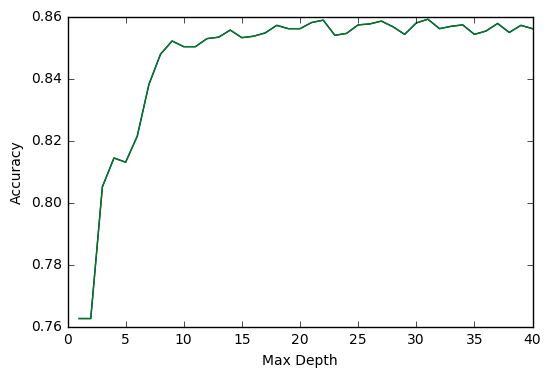

In [114]:
plt.plot(all_depth, all_l)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [149]:
# train random forest for Kaggle submission
n_trees=128
n_sample=len(train_Xib)
n_feature=-1 # -1 ==> sqrt(d)
max_depth=80

rf = random_forest(n_trees=n_trees, n_sample=n_sample, n_feature=n_feature, max_depth=max_depth)

start = time.time()
rf.train_parallel(train_Xib, train_y, verbose=False) # use all data
end = time.time()
print('Total training time: ', end-start)

# Trees = 128
Trees trained.
Total training time:  267.12233543395996


In [150]:
# predict and save labels
test_y = rf.predict(test_Xib)

In [154]:
df = pd.DataFrame({'Category': test_y.astype(int)})
df.index += 1
df.index.rename('Id', inplace=True)
df.to_csv('census_dist/census_rf_poly2_%s_binirize_nt%d_sample%d_m%d_depth%d.csv' \
          % (method, n_trees, n_sample, n_feature, max_depth))

### 3. Titanic

In [24]:
train_X = pd.read_csv('./titanic_dist/titanic_training.csv')
test_X = pd.read_csv('./titanic_dist/titanic_testing_data.csv')
train_y = train_X.pop('survived').as_matrix()
train_X.drop(['ticket', 'cabin'], inplace=True, axis=1)
test_X.drop(['ticket', 'cabin'], inplace=True, axis=1)

train_X.fillna(value='?', inplace=True)
test_X.fillna(value='?', inplace=True)

train_X.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,3,male,?,0,0,8.05,S
1,1,male,22,0,0,135.633,C
2,2,male,23,0,0,15.0458,C
3,2,male,42,0,0,13,S
4,3,male,20,0,0,9.8458,S


In [25]:
train_X = train_X.as_matrix()
test_X = test_X.as_matrix()

print(train_X.shape)
print(test_X.shape)

(1000, 7)
(310, 7)


In [36]:
# impute data
train_Xi = imputer(train_X, cols=[1,6], method='max', missing='?')
test_Xi = imputer(test_X, cols=[1,6], method='max', missing='?')
method = 'median'
train_Xi = imputer(train_Xi, cols=[0,2,3,4,5], method=method, missing='?')
test_Xi = imputer(test_Xi, cols=[0,2,3,4,5], method=method, missing='?')
all_Xi = np.vstack((train_Xi, test_Xi))

print(train_Xi.shape)
print(test_Xi.shape)

(1000, 7)
(310, 7)


In [60]:
# binarize categorical feature
lb = LabelBinarizer()


all_Xib = all_Xi[:, [0,2,3,4,5]]

for j in [1, 6]:
    b = lb.fit_transform(all_Xi[:, j])
    all_Xib = np.hstack((all_Xib, b))
    
# polynomials for the numerical features
# poly = PolynomialFeatures(2)
# all_Xib = poly.fit_transform(all_Xib)

In [61]:
train_Xib = all_Xib[:train_Xi.shape[0], :]
test_Xib = all_Xib[-test_Xi.shape[0]:, :]
print(train_Xib.shape)
print(test_Xib.shape)

(1000, 9)
(310, 9)


In [39]:
# divide data into train/validation
S = np.random.choice(range(len(train_y)), int(len(train_y)/5*4), replace=False)
train_data = train_Xib[S, :]
train_labels = train_y[S]
S = np.setdiff1d(range(len(train_y)), S)
validation_data = train_Xib[S, :]
validation_labels = train_y[S]
print(train_data.shape)
print(validation_data.shape)

(800, 9)
(200, 9)


In [51]:
dt = decision_tree(3)
start = time.time()
dt.train(train_data, train_labels)
end = time.time()
print('Total training time: ', end-start)

l = dt.accuracy(train_data, train_labels)
print('Accuracy: ', l)

l = dt.accuracy(validation_data, validation_labels)
print('Accuracy: ', l)

Total training time:  0.14397740364074707
Accuracy:  0.7925
Accuracy:  0.79


In [59]:
dt.root.right.left.label

1.0

In [32]:
# train random forest
n_trees=128
n_sample=len(train_data)
n_feature=-1 # -1 ==> sqrt(d)
max_depth=30

rf = random_forest(n_trees=n_trees, n_sample=n_sample, n_feature=n_feature, max_depth=max_depth)

start = time.time()
rf.train_parallel(train_data, train_labels, verbose=False) # use all data
end = time.time()
print('Total training time: ', end-start)

l = dt.accuracy(train_data, train_labels)
print('Accuracy: ', l)

l = rf.accuracy(validation_data, validation_labels)
print('Accuracy: ', l)

# Trees = 128


/working/lupolab/eason/anaconda3/envs/dsb2017/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in double_scalars
/working/lupolab/eason/anaconda3/envs/dsb2017/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in double_scalars
/working/lupolab/eason/anaconda3/envs/dsb2017/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in double_scalars


Trees trained.
Total training time:  3.306265354156494
Accuracy:  0.92375
Accuracy:  0.87


In [206]:
# train random forest
n_trees=128
n_sample=len(train_Xib)
n_feature=-1 # -1 ==> sqrt(d)
max_depth=80

rf = random_forest(n_trees=n_trees, n_sample=n_sample, n_feature=n_feature, max_depth=max_depth)

start = time.time()
rf.train_parallel(train_Xib, train_y, verbose=False) # use all data
end = time.time()
print('Total training time: ', end-start)

# Trees = 128


/working/lupolab/eason/anaconda3/envs/dsb2017/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in double_scalars


Trees trained.
Total training time:  5.065195560455322


In [141]:
# predict and save labels
test_y = rf.predict(test_Xib)
df = pd.DataFrame({'Category': test_y.astype(int)})
df.index += 1
df.index.rename('Id', inplace=True)
df.to_csv('titanic_dist/titanic_rf_max_binirize_nt%d_sample%d_m%d_depth%d.csv' % (n_trees, n_sample, n_feature, max_depth))

In [66]:
# writeup
graph = pydot.Dot(graph_type='graph')
graph.add_edge(pydot.Edge("sex, th=0.5 (male=1)", "pclass, th=2.5"))
graph.add_edge(pydot.Edge("sex, th=0.5 (male=1)", "age, th=9.5"))
graph.add_edge(pydot.Edge("pclass, th=2.5", "1 "))
graph.add_edge(pydot.Edge("pclass, th=2.5", "1  "))
graph.add_edge(pydot.Edge("age, th=9.5", "1"))
graph.add_edge(pydot.Edge("age, th=9.5", "0"))
# ok, we are set, let's save our graph into a file
graph.write_png('graph.png')

True